In [50]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sn
import thinkplot
from thinkdsp import read_wave
from matplotlib import pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

edgePath = r'C:\Users\Vaclav\Documents\Diploma\Notebooks\Classifier\ImageBase\Edges'
linePath = r'C:\Users\Vaclav\Documents\Diploma\Notebooks\Classifier\ImageBase\Lines'

# Сохранение графика в png\jpg\pdf
def plot_save(wave, root, formats,**options):
        fs = wave.frequencies()
        i = None
        fs = fs[:i]
        ts = wave.times()
        size = len(fs), len(ts)
        array = np.zeros(size, dtype=np.float)
        for j, t in enumerate(ts):
            spectrum = wave.spec_map[t]
            array[:, j] = spectrum.amps[:i]
        
        thinkplot.pcolor(ts, fs, array, pcolor=True, contour=False, **options)
        thinkplot.save(root, formats, **options)

# Класс для подготовки к преобразованию Хафа (определение граней)
class EdgeFinder:
    def __init__(   self, image, filter_size=7, threshold1=155, threshold2=115,
                    rho = 1, theta = np.pi/180, min_votes = 20, min_line_length = 30, max_line_gap = 50,
                    cv_color=cv2.COLOR_RGB2GRAY, color=[255, 0, 0], thickness=4, mean_rate = 0.9, 
                    pos_intersect_ratio=10, neg_intersect_ratio=10):
                    
        self.orig_image = image
        self._cv_color = cv_color #cv2.COLOR_BGR2GRAY or cv2.COLOR_RGB2GRAY
        self.image = self._grayscale(image)
        self._filter_size = filter_size
        self._threshold1 = threshold1
        self._threshold2 = threshold2

        self._rho = rho # метрика расстояния Hough grid
        self._theta = theta # угловая метрика в радианах для Hough grid
        self._min_votes = min_votes     # минимальное количество голосов
        self._min_line_length = min_line_length # минимальное количество пикселей в линии
        self._max_line_gap = max_line_gap    # максимальное расстояние между линиями

        self._color = color
        self._thickness = thickness
        self._pos_intersect_ratio = pos_intersect_ratio
        self._neg_intersect_ratio = neg_intersect_ratio
        self._line_list = []
        
        def onchangeThreshold1(pos):
            self._threshold1 = pos
            self._render()

        def onchangeThreshold2(pos):
            self._threshold2 = pos
            self._render()

        def onchangeFilterSize(pos):
            self._filter_size = pos
            self._filter_size += (self._filter_size + 1) % 2
            self._render()

        def onchangeRho(pos):
            self._rho = np.max([pos, 1])
            self._render()

        def onchangeTheta(pos):
            self._theta = np.max([pos*np.pi/180.0, np.pi/180.0])
            self._render()

        def onchangeMinVotes(pos):
            self._min_votes = pos
            self._render()

        def onchangeMinLineLength(pos):
            self._min_line_length = pos
            self._render()

        def onchangeMaxLineGap(pos):
            self._max_line_gap = pos
            self._render()

        self._render()

    ## Представление изображения в двухцветном формате
    def _grayscale(self, img):
        return cv2.cvtColor(img, self._cv_color)

    # Отрисовка линий
    def _draw_lines(self, img, lines):
        try:
            for line in lines:
                for x1,y1,x2,y2 in line:
                    if abs(x2-x1) < 0.01:
                        continue
                    slope = round((y2-y1)/(x2-x1),1)
                    if np.isnan(slope) or np.isinf(slope):
                        continue
                    intercept = int(round(y1 - slope*x1))
                    if slope > 0 and ((x1+x2<img.shape[1]) or(intercept<img.shape[0]//self._pos_intersect_ratio)):
                        cv2.line(img, (x1, y1), (x2, y2), [0, 0, 255], self._thickness)
                    elif slope < 0 and ((x1+x2>img.shape[1]) or(intercept<(img.shape[0] + img.shape[0]//self._neg_intersect_ratio))):
                        cv2.line(img, (x1, y1), (x2, y2), [0, 0, 255], self._thickness)
                    elif abs(slope) < 0.5 or abs(slope) > 0.85:
                        cv2.line(img, (x1, y1), (x2, y2), [0, 0, 255], self._thickness)
                    else:
                        cv2.line(img, (x1, y1), (x2, y2), self._color, self._thickness)
        except Exception:
            print("No lines detected.")
                    
    def _hough_lines(self, img):
        """
        Подготовка параметров и выполение преобразования Хафа
        """
        lines = cv2.HoughLinesP(img, self._rho, self._theta, self._min_votes, np.array([]), 
            minLineLength=self._min_line_length, maxLineGap=self._max_line_gap)
        self._line_list.append(lines)
        line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
        self._draw_lines(line_img, lines)
        
        return line_img

    def threshold1(self):
        return self._threshold1

    def threshold2(self):
        return self._threshold2

    def filterSize(self):
        return self._filter_size
        
    def rho(self):
        return self._rho
        
    def theta(self):
        return self._theta
        
    def min_votes(self):
        return self._min_votes

    def min_line_length(self):
        return self._min_line_length

    def max_line_gap(self):
        return self._max_line_gap
        
    def edgeImage(self):
        return self._edge_img

    def smoothedImage(self):
        return self._smoothed_img

    def houghImage(self):
        return self._hough_img
    
    def getLinesList(self):
        return self._line_list

    def _render(self):
        self._smoothed_img = cv2.GaussianBlur(self.image, (self._filter_size, self._filter_size), sigmaX=0, sigmaY=0)
        self._edge_img = cv2.Canny(self._smoothed_img, self._threshold1, self._threshold2)
        self._hough_img = self._hough_lines(self._edge_img)
        # Draw the lines on the edge image
        self._hough_img = cv2.addWeighted(self._hough_img, 0.8, self.orig_image, 1., 0.)
        cv2.imwrite(os.path.join(edgePath, 'edges_'+filename),self._edge_img)    
        cv2.imwrite(os.path.join(linePath, 'lines_'+filename),self._hough_img)

In [26]:
## USE ONLY ONCE

#for filename in os.listdir('C:/Users/Vaclav/Documents/Diploma/Clean Signals/ETHALON_SIGNAL'):
#    wave = read_wave('C:/Users/Vaclav/Documents/Diploma/Clean Signals/ETHALON_SIGNAL/'+filename)
#    wave.normalize()
#    filename = os.path.splitext(filename)[0]
#    sig = wave.make_spectrogram(256)
#    plot_save(sig, filename, ['png'])
#    filename = filename+'.png'
#    img = cv2.imread(filename)
#    edge_finder = EdgeFinder(img, color=[0, 0, 255], filter_size=7, threshold1=155, threshold2=115)

In [24]:
## Генерация граней и отрисовка линий (png)

lines = []
for filename in os.listdir('C:/Users/Vaclav/Documents/Diploma/Clean Signals/ETHALON_SIGNAL'):
    filename = os.path.splitext(filename)[0]+'.png'
    img = cv2.imread(filename)
    edge_finder = EdgeFinder(img, color=[0, 0, 255], filter_size=7, threshold1=155, threshold2=115)
    lines.append(edge_finder.getLinesList())

In [25]:
## Info about Hough Transform

print("Edge parameters:")
print("GaussianBlur Filter Size: %d" % edge_finder.filterSize())
print("Threshold1: %d" % edge_finder.threshold1())
print("Threshold2: %d" % edge_finder.threshold2())

print("Rho: %d" % edge_finder.rho())
print("Theta: %f" % edge_finder.theta())
print("Min Votes: %d" % edge_finder.min_votes())
print("min_line_length: %d" % edge_finder.min_line_length())
print("max_line_gap: %d" % edge_finder.max_line_gap())

Edge parameters:
GaussianBlur Filter Size: 7
Threshold1: 155
Threshold2: 115
Rho: 1
Theta: 0.017453
Min Votes: 20
min_line_length: 30
max_line_gap: 50


In [27]:
## Создаем список линий

listOfLines = []
llines = []
i = 0
for i in list(range(0, 314, 1)):
    listOfLines.append(lines[i][0].tolist())
llines = listOfLines

for i in list(range(0, 314, 1)):
    for j in list(range(0, len(llines[i]), 1)):
        listOfLines[i][j] = llines[i][j][0]

In [116]:
## Создаем датафрейм с информацией о сигналах с учетом масштаба графика

dfList = []
i = 0
for i in list(range(314)):
    df = pd.DataFrame(listOfLines[i], columns=['X1', 'Y1', 'X2', 'Y2'])
    df['X1'] = df['X1'].apply(lambda x: x*0.001613).round(1)
    df['X2'] = df['X2'].apply(lambda x: x*0.001613).round(1)
    df['Y1'] = df['Y1'].apply(lambda y: y*3.759398).round(2)
    df['Y2'] = df['Y2'].apply(lambda y: y*3.759398).round(2)
    dfList.append(df)
    
listOfFilteredSignalLines = []
i = 0
while i < 314:
    listOfFilteredSignalLines.append(uniqueRows(dfList[i]))
    i = i + 1

In [246]:
## Поиск ближайшего числа
def closest(lst, K): 
    lst = np.asarray(lst) 
    idx = (np.abs(lst - K)).argmin() 
    return lst[idx] 

## Фильтр дубликатов и вычисление средних линий
def uniqueRows(df):
    dfObj = pd.DataFrame()
    listOfUniqueX1 = df['X1'].unique().tolist()
    for uniq in listOfUniqueX1:
        dataFrame = df.loc[lambda df: df['X1'] == uniq]
        dfObj = dfObj.append(dataFrame[(dataFrame['X1'] == uniq) & (dataFrame['Y1'] == closest(dataFrame['Y1'], dataFrame['Y1'].mean()))], ignore_index=True)
    return dfObj  

## Вычисление параметров сигналов
def getSignalParams(dfList):
    dfObj = pd.DataFrame()
    for df in dfList:
        paramsList = []
        paramsList.append(abs(round(df['X2'].max() - df['X1'].min(), 2)))
        paramsList.append(df['Y1'].min())
        paramsList.append(df['Y2'].max())
        paramsList.append(round((df['Y1'].mean() + df['Y2'].mean())/2, 2))
        paramsList.append(abs(round(df['Y2'].max() - df['Y1'].min(), 2)))
        paramsList.append(len(df))
        dfOb = pd.DataFrame(paramsList).transpose()
        dfOb.columns=['Length','Lowest Frequency','Highest Frequency','Average Frequency','Frequency Band','Impulse Count']
        dfObj = dfObj.append(dfOb, ignore_index=True)
    return dfObj

## Вычисления полной информации о параметрах импульсов
def getImpulseParams(df):
    dfObj = pd.DataFrame()
    for index, row in df.iterrows():
        paramsList = []
        paramsList.append(abs(round(row['X2'] - row['X1'], 2)))
        paramsList.append(row['Y1'])
        paramsList.append(row['Y2'])
        paramsList.append(round((row['Y1'] + row['Y2'])/2, 2))
        band = round(row['Y2'] - row['Y1'], 2)
        paramsList.append(band)
        if (int(band) > 0):
            paramsList.append('Increases')
        elif (int(band) < 0):
            paramsList.append('Decreases')
        else:
            paramsList.append('Constant')
        dfOb = pd.DataFrame(paramsList).transpose()
        dfOb.columns=['Length','Lowest Frequency','Highest Frequency','Average Frequency','Frequency Band','Impulse Direction']
        dfObj = dfObj.append(dfOb, ignore_index=True)
    return dfObj 

## Вычисления усредненной информации о параметрах импульсов
def getAverageImpulseParams(dfList):
    dfFin = pd.DataFrame()
    for df in dfList:
        dfObj = pd.DataFrame()
        for index, row in df.iterrows():
            paramsList = []
            paramsList.append(abs(round(row['X2'] - row['X1'], 2)))
            paramsList.append(row['Y1'])
            paramsList.append(row['Y2'])
            paramsList.append(round((row['Y1'] + row['Y2'])/2, 2))
            band = round(row['Y2'] - row['Y1'], 2)
            paramsList.append(band)
            if (int(band) > 0):
                paramsList.append('Increases')
            elif (int(band) < 0):
                paramsList.append('Decreases')
            else:
                paramsList.append('Constant')
            dfOb = pd.DataFrame(paramsList).transpose()
            dfOb.columns=['Length','Lowest Frequency','Highest Frequency','Average Frequency','Frequency Band','Impulse Direction']
            dfObj = dfObj.append(dfOb, ignore_index=True)
        paramsList = []
        paramsList.append(dfObj['Length'].mean())
        paramsList.append(dfObj['Frequency Band'].mean())
        paramsList.append(dfObj['Impulse Direction'].value_counts().idxmax())
        df = pd.DataFrame(paramsList).transpose()
        df.columns=['Average Length','Average Frequency Band','Common Direction']
        dfFin = dfFin.append(df, ignore_index=True)
    return dfFin

In [247]:
listOfFilteredSignalLines[232]

,X1,Y1,X2,Y2
0,2.9,7672.93,3.0,7669.17
1,3.4,7612.78,3.5,7612.78
2,1.0,7680.45,1.1,7680.45
3,4.3,8507.52,4.3,8312.03
4,1.8,7680.45,1.9,7680.45
5,3.0,7748.12,3.0,7624.06
6,4.4,8507.52,4.4,8255.64
7,4.5,7627.82,4.5,7751.88
8,1.1,7804.51,1.1,7687.97
9,1.9,8312.03,1.9,8180.45


In [248]:
getAverageImpulseParams(listOfFilteredSignalLines).to_csv("getAverageImpulseParams.csv", sep='\t', encoding='utf-8', index=False)

In [249]:
getSignalParams(listOfFilteredSignalLines).to_csv("getSignalParams.csv", sep='\t', encoding='utf-8', index=False)

In [250]:
## MAY START HERE NOW

learningDataframe = pd.read_csv('getSignalParams.csv', sep='\t') 
learningDataframe

,Length,Lowest Frequency,Highest Frequency,Average Frequency,Frequency Band,Impulse Count
0,1.7,6379.70,6428.57,6417.29,48.87,5.0
1,1.2,6285.71,6492.48,6395.78,206.77,9.0
2,2.5,6281.95,6428.57,6351.90,146.62,14.0
3,1.9,6353.38,6428.57,6393.48,75.19,9.0
4,1.9,6349.62,6424.81,6380.48,75.19,12.0
...,...,...,...,...,...,...
309,2.3,6353.38,6428.57,6362.97,75.19,10.0
310,4.6,6353.38,8578.95,7700.10,2225.57,11.0
311,0.3,6424.81,6424.81,6424.81,0.00,1.0
312,1.0,6424.81,6496.24,6465.63,71.43,7.0


In [251]:
getAverageImpulseParams = pd.read_csv('getAverageImpulseParams.csv', sep='\t') 

In [252]:
finalLearningDataframe = pd.concat([learningDataframe,getAverageImpulseParams], ignore_index=True, axis=1)
finalLearningDataframe.columns=['Length','Lowest Frequency','Highest Frequency','Average Frequency','Frequency Band','Impulse Count', 'Average Impulse Length','Average Impulse Frequency Band','Common Impulse Direction']
dfMap = {'Increases': 1, 'Constant': 0, 'Decreases': -1}
finalLearningDataframe['Common Impulse Direction'] = finalLearningDataframe['Common Impulse Direction'].map(dfMap)
finalLearningDataframe.to_csv("finalLearningDataframe.csv", sep='\t', encoding='utf-8', index=False)
finalLearningDataframe = pd.read_csv('finalLearningDataframe.csv', sep='\t') 
finalLearningDataframe

,Length,Lowest Frequency,Highest Frequency,Average Frequency,Frequency Band,Impulse Count,Average Impulse Length,Average Impulse Frequency Band,Common Impulse Direction
0,1.7,6379.70,6428.57,6417.29,48.87,5.0,0.820000,0.000000,0
1,1.2,6285.71,6492.48,6395.78,206.77,9.0,0.200000,-1.253333,0
2,2.5,6281.95,6428.57,6351.90,146.62,14.0,0.378571,13.158571,0
3,1.9,6353.38,6428.57,6393.48,75.19,9.0,0.344444,0.000000,0
4,1.9,6349.62,6424.81,6380.48,75.19,12.0,0.266667,-20.364167,0
...,...,...,...,...,...,...,...,...,...
309,2.3,6353.38,6428.57,6362.97,75.19,10.0,0.160000,-1.880000,0
310,4.6,6353.38,8578.95,7700.10,2225.57,11.0,0.054545,-31.100909,-1
311,0.3,6424.81,6424.81,6424.81,0.00,1.0,0.300000,0.000000,0
312,1.0,6424.81,6496.24,6465.63,71.43,7.0,0.214286,-1.074286,0


Estimated number of clusters: 5
Estimated number of noise points: 20


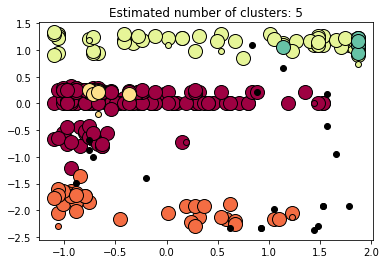

In [253]:
## SIGNAL CLUSTERIZATOR
# #############################################################################
# Generate sample data

X = StandardScaler().fit_transform(learningDataframe)

# #############################################################################
# Compute DBSCAN
db = DBSCAN(eps=0.9, min_samples=5).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

# #############################################################################
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

dbResult = DBSCAN(eps=0.9, min_samples=5).fit_predict(X)
clusteredLearningDataframe = learningDataframe.join(pd.DataFrame({'Cluster': dbResult}))

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [254]:
clusteredLearningDataframe

,Length,Lowest Frequency,Highest Frequency,Average Frequency,Frequency Band,Impulse Count,Cluster
0,1.7,6379.70,6428.57,6417.29,48.87,5.0,0
1,1.2,6285.71,6492.48,6395.78,206.77,9.0,0
2,2.5,6281.95,6428.57,6351.90,146.62,14.0,0
3,1.9,6353.38,6428.57,6393.48,75.19,9.0,0
4,1.9,6349.62,6424.81,6380.48,75.19,12.0,0
...,...,...,...,...,...,...,...
309,2.3,6353.38,6428.57,6362.97,75.19,10.0,0
310,4.6,6353.38,8578.95,7700.10,2225.57,11.0,-1
311,0.3,6424.81,6424.81,6424.81,0.00,1.0,0
312,1.0,6424.81,6496.24,6465.63,71.43,7.0,0


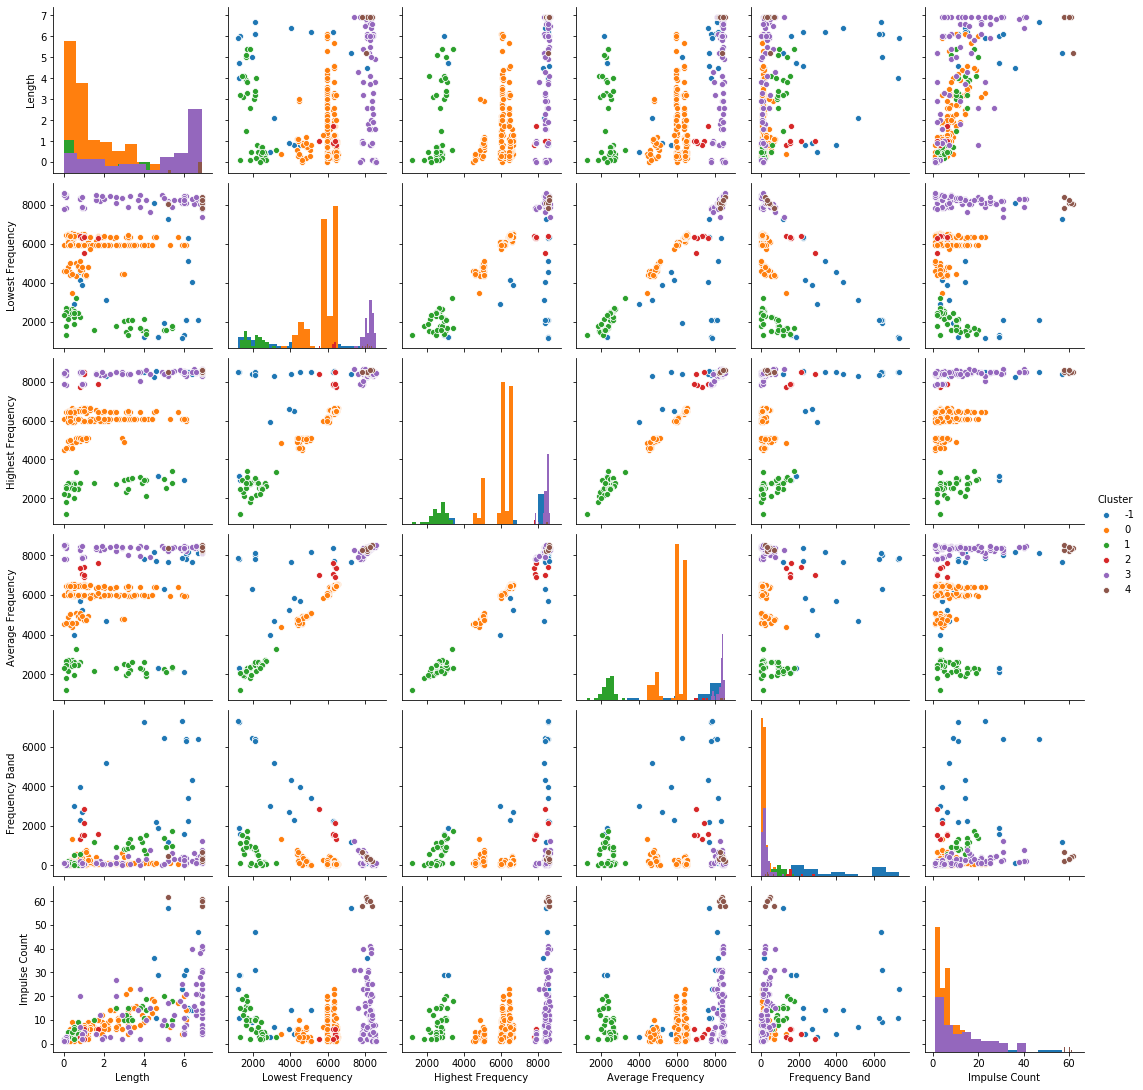

In [255]:
sn.pairplot(data=clusteredLearningDataframe, hue="Cluster", diag_kind='hist')

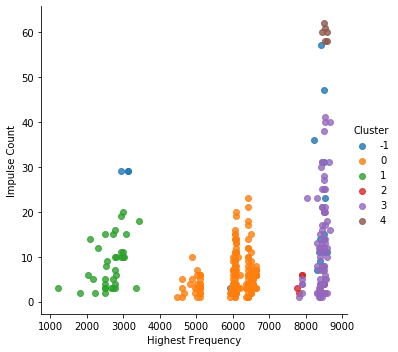

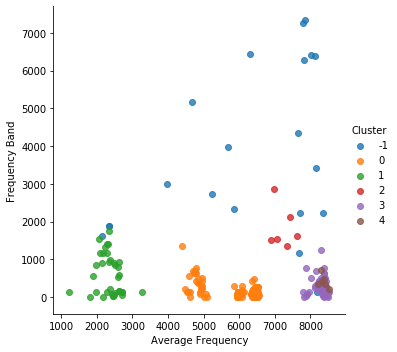

In [256]:
sn.lmplot('Highest Frequency', 'Impulse Count', data=clusteredLearningDataframe, hue="Cluster", fit_reg=False)
sn.lmplot('Average Frequency', 'Frequency Band', data=clusteredLearningDataframe, hue="Cluster", fit_reg=False)

In [257]:
impulseDf = getImpulseParams(listOfFilteredSignalLines[232])
dfMap = {'Increases': 1, 'Constant': 0, 'Decreases': -1}
impulseDf['Impulse Direction'] = impulseDf['Impulse Direction'].map(dfMap)
impulseDf

,Length,Lowest Frequency,Highest Frequency,Average Frequency,Frequency Band,Impulse Direction
0,0.1,7672.93,7669.17,7671.05,-3.76,-1
1,0.1,7612.78,7612.78,7612.78,0,0
2,0.1,7680.45,7680.45,7680.45,0,0
3,0,8507.52,8312.03,8409.78,-195.49,-1
4,0.1,7680.45,7680.45,7680.45,0,0
5,0,7748.12,7624.06,7686.09,-124.06,-1
6,0,8507.52,8255.64,8381.58,-251.88,-1
7,0,7627.82,7751.88,7689.85,124.06,1
8,0,7804.51,7687.97,7746.24,-116.54,-1
9,0,8312.03,8180.45,8246.24,-131.58,-1


Estimated number of clusters: 11
Estimated number of noise points: 0


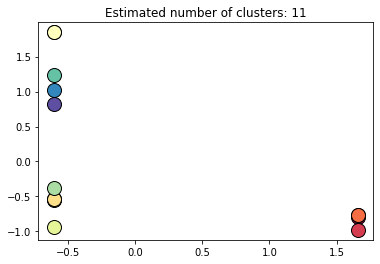

In [258]:
## IMPULSE CLUSTERIZATOR
# #############################################################################
# Generate sample data

X = StandardScaler().fit_transform(impulseDf)

# #############################################################################
# Compute DBSCAN
db = DBSCAN(eps=0.3, min_samples=1).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

# #############################################################################
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

dbResult = DBSCAN(eps=0.3, min_samples=1).fit_predict(X)
clusteredImpulseDf = impulseDf.join(pd.DataFrame({'Cluster': dbResult}))

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [259]:
clusteredImpulseDf

,Length,Lowest Frequency,Highest Frequency,Average Frequency,Frequency Band,Impulse Direction,Cluster
0,0.1,7672.93,7669.17,7671.05,-3.76,-1,0
1,0.1,7612.78,7612.78,7612.78,0,0,1
2,0.1,7680.45,7680.45,7680.45,0,0,2
3,0,8507.52,8312.03,8409.78,-195.49,-1,3
4,0.1,7680.45,7680.45,7680.45,0,0,2
5,0,7748.12,7624.06,7686.09,-124.06,-1,4
6,0,8507.52,8255.64,8381.58,-251.88,-1,5
7,0,7627.82,7751.88,7689.85,124.06,1,6
8,0,7804.51,7687.97,7746.24,-116.54,-1,7
9,0,8312.03,8180.45,8246.24,-131.58,-1,8


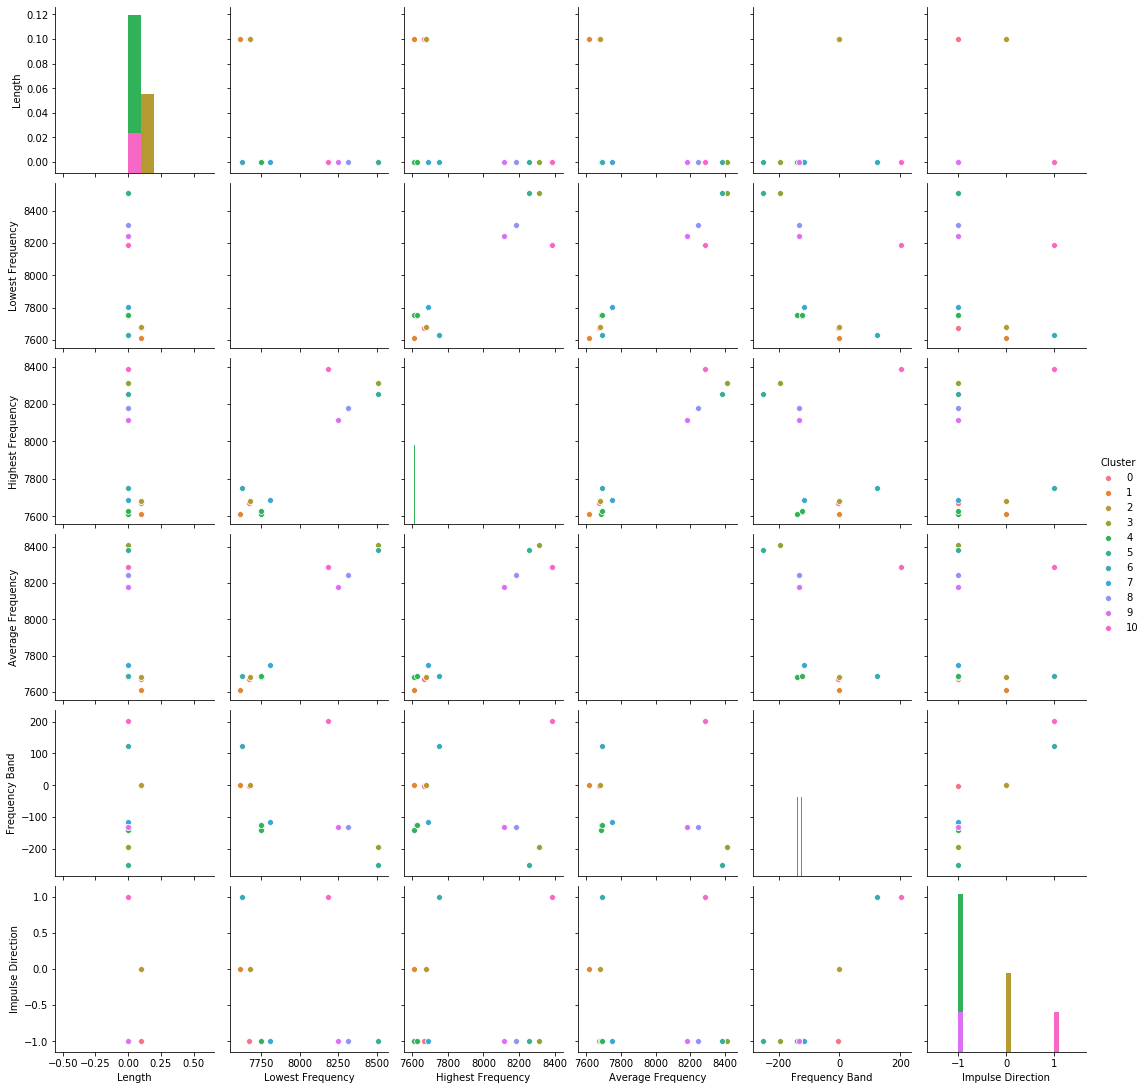

In [260]:
sn.pairplot(data=clusteredImpulseDf, hue='Cluster', diag_kind='hist')

Estimated number of clusters: 7
Estimated number of noise points: 36


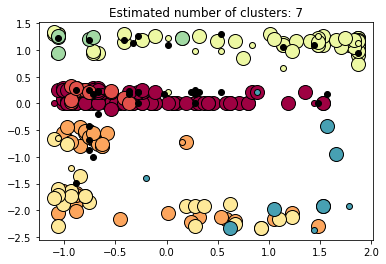

In [353]:
## Кластеризация сигналов и импульсов

# Подготовка данных

X = StandardScaler().fit_transform(finalLearningDataframe)

# Построение модели DBSCAN
db = DBSCAN(eps=0.09, min_samples=4, metric='cosine').fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Вычисление количества кластеров
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

# Визуализация результатов
import matplotlib.pyplot as plt

# Построение графика и удаление шума
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

dbResult = DBSCAN(eps=0.09, min_samples=4, metric='cosine').fit_predict(X)
clustered = finalLearningDataframe.join(pd.DataFrame({'Cluster': dbResult}))

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

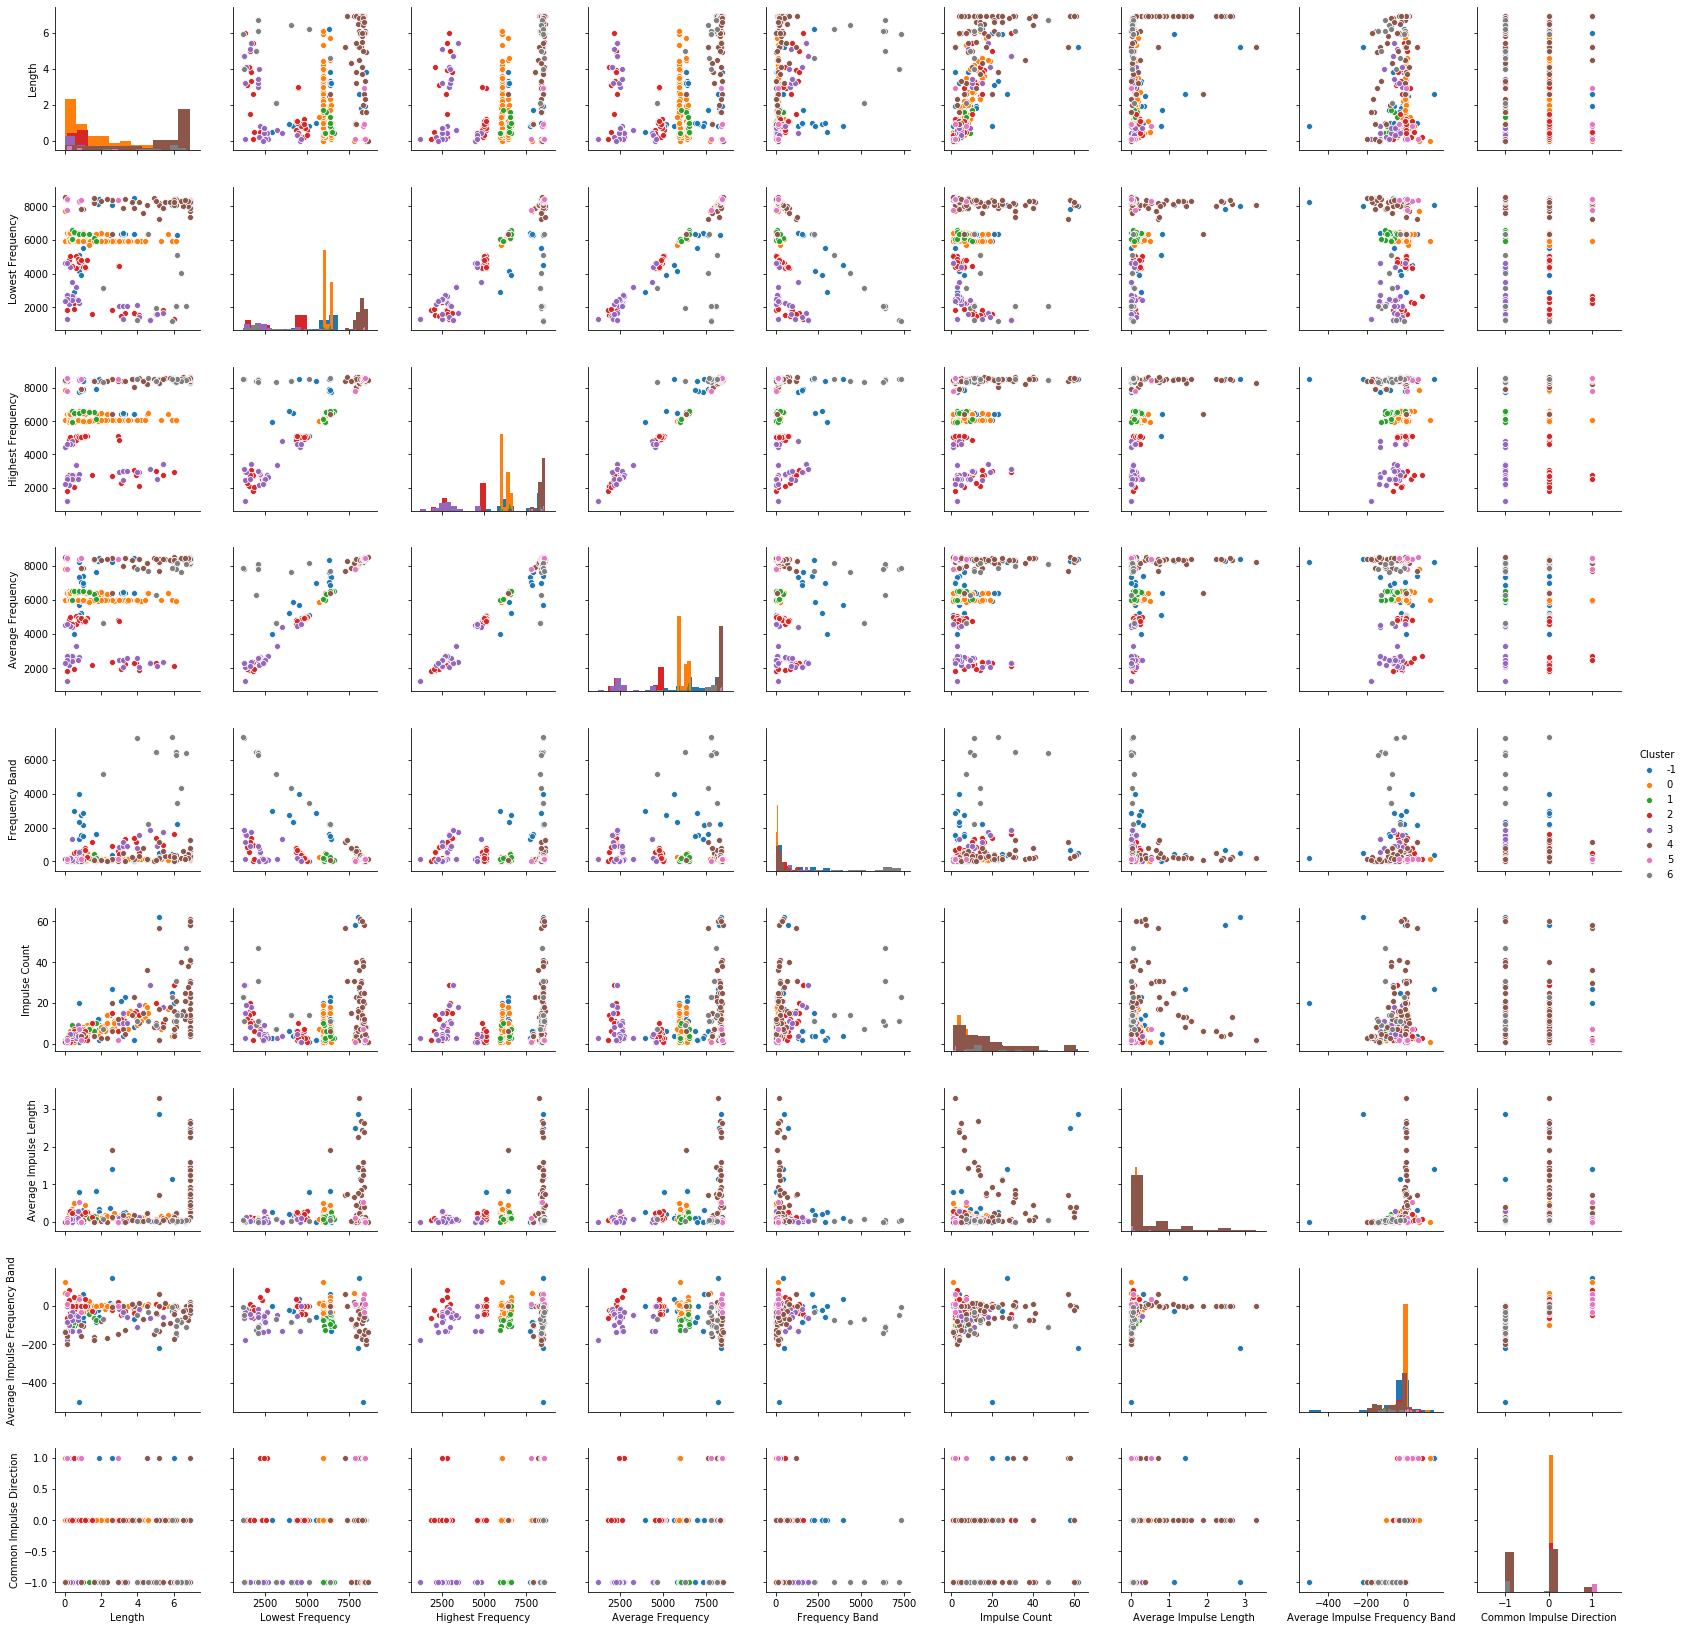

In [357]:
sns_plot = sn.pairplot(data=clustered, hue='Cluster', diag_kind='hist')
sns_plot.savefig("pairplot.png")

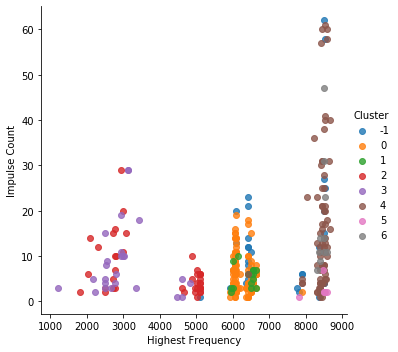

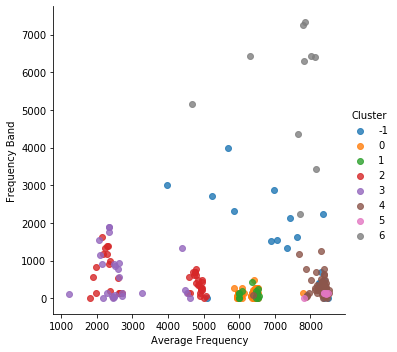

In [356]:
sn.lmplot('Highest Frequency', 'Impulse Count', data=clustered, hue="Cluster", fit_reg=False)
sn.lmplot('Average Frequency', 'Frequency Band', data=clustered, hue="Cluster", fit_reg=False)